# Recipe Generation using Recurrent Neural Network (RNN)

## Importing dependencies

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import platform
import time
import pathlib
import os
import json

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.7.6
Tensorflow version: 2.1.0
Keras version: 2.2.4-tf


## Exploring datasets

- 🤷 [Recipe Ingredients Dataset](https://www.kaggle.com/kaggle/recipe-ingredients-dataset/home) _(doesn't have ingredients proportions)_
- 🤷 [Recipe1M+](http://pic2recipe.csail.mit.edu/) _(requires registration to download)_
- 🤷 [Epicurious - Recipes with Rating and Nutrition](https://www.kaggle.com/hugodarwood/epirecipes?select=full_format_recipes.json) _(~20k recipes only, it would be nice to find more)_
- 👍🏻 [**Recipe box**](https://eightportions.com/datasets/Recipes/) _(~125,000 recipes with ingredients proportions)_

## Loading the dataset

In [2]:
# Create cache folder.
cache_dir = './tmp'
pathlib.Path(cache_dir).mkdir(exist_ok=True)

In [3]:
# Download and unpack the dataset.
dataset_file_name = 'recipes_raw.zip'
dataset_file_origin = 'https://storage.googleapis.com/recipe-box/recipes_raw.zip'

dataset_file_path = tf.keras.utils.get_file(
    fname=dataset_file_name,
    origin=dataset_file_origin,
    cache_dir=cache_dir,
    extract=True,
    archive_format='zip'
)

print(dataset_file_path)

./tmp/datasets/recipes_raw.zip


In [4]:
!ls -la ./tmp/datasets/

total 521128
drwxr-xr-x  7 trekhleb  staff       224 May 13 18:10 .
drwxr-xr-x  3 trekhleb  staff        96 May 13 18:10 ..
-rw-r--r--  1 trekhleb  staff     20437 May 14 18:15 LICENSE
-rw-r--r--  1 trekhleb  staff  53355492 May 13 18:10 recipes_raw.zip
-rw-r--r--  1 trekhleb  staff  49784325 May 14 18:15 recipes_raw_nosource_ar.json
-rw-r--r--  1 trekhleb  staff  61133971 May 14 18:15 recipes_raw_nosource_epi.json
-rw-r--r--  1 trekhleb  staff  93702755 May 14 18:15 recipes_raw_nosource_fn.json


In [5]:
def load_dataset(silent=False):
    dataset_file_names = [
        'recipes_raw_nosource_ar.json',
        'recipes_raw_nosource_epi.json',
        'recipes_raw_nosource_fn.json',
    ]
    
    dataset = []

    for dataset_file_name in dataset_file_names:
        dataset_file_path = f'{cache_dir}/datasets/{dataset_file_name}'

        with open(dataset_file_path) as dataset_file:
            json_data_dict = json.load(dataset_file)
            json_data_list = list(json_data_dict.values())
            dict_keys = [key for key in json_data_list[0]]
            dict_keys.sort()
            dataset += json_data_list

            if silent == False:
                print(dataset_file_path)
                print('===========================================')
                print('Number of examples: ', len(json_data_list), '\n')
                print('Example object keys:\n', dict_keys, '\n')
                print('Example object:\n', json_data_list[0], '\n')
                print('Required keys:\n')
                print('  title: ', json_data_list[0]['title'], '\n')
                print('  ingredients: ', json_data_list[0]['ingredients'], '\n')
                print('  instructions: ', json_data_list[0]['instructions'])
                print('\n\n')
    
    return dataset  

In [6]:
dataset_raw = load_dataset()  

./tmp/datasets/recipes_raw_nosource_ar.json
Number of examples:  39802 

Example object keys:
 ['ingredients', 'instructions', 'picture_link', 'title'] 

Example object:
 {'title': 'Slow Cooker Chicken and Dumplings', 'ingredients': ['4 skinless, boneless chicken breast halves ADVERTISEMENT', '2 tablespoons butter ADVERTISEMENT', '2 (10.75 ounce) cans condensed cream of chicken soup ADVERTISEMENT', '1 onion, finely diced ADVERTISEMENT', '2 (10 ounce) packages refrigerated biscuit dough, torn into pieces ADVERTISEMENT', 'ADVERTISEMENT'], 'instructions': 'Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.\nCover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.\n', 'picture_link': '55lznCYBbs2mT8BTx6BTkLhynGHzM.S'} 

Required keys:

  title:  Slow Cooker Chicken and Dumplings 

  ingredients:  ['4 skinless, boneless chicke

In [7]:
print('Total number of examples: ', len(dataset_raw))

Total number of examples:  125164


## Preprocessing the dataset

### Converting recipes objects to strings

In [8]:
def recipe_validate(recipe):
    required_keys = ['title', 'ingredients', 'instructions']
    
    if not recipe:
        return False
    
    for required_key in required_keys:
        if not recipe[required_key]:
            return False
        
        if type(recipe[required_key]) == list and len(recipe[required_key]) == 0:
            return False
    
    return True

In [9]:
STOP_SIGN = '★'

In [10]:
def recipe_to_string(recipe):
    noize_string = 'ADVERTISEMENT'
    
    title = recipe['title']
    ingredients = recipe['ingredients']
    instructions = recipe['instructions'].split('\n')
    
    ingredients_string = ''
    for ingredient in ingredients:
        ingredient = ingredient.replace(noize_string, '')
        if ingredient:
            ingredients_string += f'\n• {ingredient}'
    
    instructions_string = ''
    for instruction in instructions:
        instruction = instruction.replace(noize_string, '')
        if instruction:
            instructions_string += f'\n▪︎ {instruction}'
    
    return f'[TITLE] \n{title} \n\n[INGREDIENTS] {ingredients_string} \n\n[INSTRUCTIONS] {instructions_string}\n\n{STOP_SIGN}'

In [33]:
dataset_filtered = [recipe for recipe in dataset_raw if recipe_validate(recipe)]

TOTAL_RECIPES_NUM = len(dataset_filtered)

print('Dataset size BEFORE filtering', len(dataset_raw))
print('Dataset size AFTER filtering', len(dataset_filtered))
print('Number of invalide recipes', len(dataset_raw) - len(dataset_filtered))

Dataset size BEFORE filtering 125164
Dataset size AFTER filtering 122938
Number of invalide recipes 2226


In [12]:
dataset_stringified = [recipe_to_string(recipe) for recipe in dataset_filtered]

print('Dataset size: ', len(dataset_stringified))

Dataset size:  122938


In [13]:
for recipe_string in dataset_stringified[:5]:
    print(recipe_string)

[TITLE] 
Slow Cooker Chicken and Dumplings 

[INGREDIENTS] 
• 4 skinless, boneless chicken breast halves 
• 2 tablespoons butter 
• 2 (10.75 ounce) cans condensed cream of chicken soup 
• 1 onion, finely diced 
• 2 (10 ounce) packages refrigerated biscuit dough, torn into pieces  

[INSTRUCTIONS] 
▪︎ Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.
▪︎ Cover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.

★
[TITLE] 
Awesome Slow Cooker Pot Roast 

[INGREDIENTS] 
• 2 (10.75 ounce) cans condensed cream of mushroom soup 
• 1 (1 ounce) package dry onion soup mix 
• 1 1/4 cups water 
• 5 1/2 pounds pot roast  

[INSTRUCTIONS] 
▪︎ In a slow cooker, mix cream of mushroom soup, dry onion soup mix and water. Place pot roast in slow cooker and coat with soup mixture.
▪︎ Cook on High setting for 3 to 4 hours, or on Low setting 

## Creating vocabulary

In [14]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    char_level=True,
    filters='',
    lower=False,
    split=''
)

In [15]:
tokenizer.fit_on_texts(dataset_stringified)

In [16]:
print('Total number of unique chars: ', len(tokenizer.word_counts))

Total number of unique chars:  206


In [17]:
tokenizer.get_config()

{'num_words': None,
 'filters': '',
 'lower': False,
 'split': '',
 'char_level': True,
 'oov_token': None,
 'document_count': 122938,
 'word_counts': '{"[": 368900, "T": 799961, "I": 741986, "L": 202020, "E": 397809, "]": 368901, " ": 29686774, "\\n": 2631922, "S": 777322, "l": 6434277, "o": 10024677, "w": 1661930, "C": 459399, "k": 1504355, "e": 15389300, "r": 7995581, "h": 5016336, "i": 8312379, "c": 4647540, "n": 8887313, "a": 10173459, "d": 5163618, "D": 231069, "u": 4554913, "m": 3063209, "p": 4284716, "g": 2860143, "s": 7830993, "N": 511209, "G": 200186, "R": 419077, "\\u2022": 1277532, "4": 366806, ",": 1885193, "b": 2334499, "t": 10381678, "v": 1255482, "2": 768729, "(": 236414, "1": 1292716, "0": 240409, ".": 1809973, "7": 46087, "5": 245798, ")": 236417, "f": 1882850, "y": 1183382, "U": 155543, "O": 169659, "\\u25aa": 494195, "\\ufe0e": 494195, "P": 309978, "6": 83546, "H": 68917, "A": 233117, "3": 348688, "\\u2605": 122938, "x": 322179, "/": 530492, "8": 89871, "9": 26674, 

In [18]:
tokenizer.word_index[STOP_SIGN]

62

In [19]:
print(tokenizer.index_word[58])
print(tokenizer.index_word[62])

j
★


## Vectorizing the dataset

In [38]:
def recipe_sequence_to_string(recipe_sequence):
    recipe_stringified = tokenizer.sequences_to_texts([recipe_sequence])[0]
    recipe_stringified = recipe_stringified.replace('   ', '_').replace(' ', '').replace('_', ' ')
    print(recipe_stringified)

In [20]:
dataset_vectorized = tokenizer.texts_to_sequences(dataset_stringified)

In [21]:
print(len(dataset_vectorized))

122938


In [22]:
dataset_vectorized[0]

[42,
 29,
 32,
 29,
 53,
 39,
 41,
 1,
 18,
 30,
 10,
 5,
 23,
 1,
 37,
 5,
 5,
 24,
 2,
 8,
 1,
 37,
 12,
 7,
 13,
 24,
 2,
 6,
 1,
 4,
 6,
 11,
 1,
 52,
 14,
 16,
 15,
 10,
 7,
 6,
 17,
 9,
 1,
 18,
 18,
 42,
 32,
 34,
 54,
 38,
 39,
 52,
 32,
 39,
 34,
 29,
 30,
 41,
 1,
 18,
 26,
 1,
 43,
 1,
 9,
 24,
 7,
 6,
 10,
 2,
 9,
 9,
 20,
 1,
 19,
 5,
 6,
 2,
 10,
 2,
 9,
 9,
 1,
 13,
 12,
 7,
 13,
 24,
 2,
 6,
 1,
 19,
 8,
 2,
 4,
 9,
 3,
 1,
 12,
 4,
 10,
 27,
 2,
 9,
 1,
 18,
 26,
 1,
 31,
 1,
 3,
 4,
 19,
 10,
 2,
 9,
 15,
 5,
 5,
 6,
 9,
 1,
 19,
 14,
 3,
 3,
 2,
 8,
 1,
 18,
 26,
 1,
 31,
 1,
 50,
 25,
 48,
 22,
 70,
 47,
 1,
 5,
 14,
 6,
 13,
 2,
 49,
 1,
 13,
 4,
 6,
 9,
 1,
 13,
 5,
 6,
 11,
 2,
 6,
 9,
 2,
 11,
 1,
 13,
 8,
 2,
 4,
 16,
 1,
 5,
 21,
 1,
 13,
 12,
 7,
 13,
 24,
 2,
 6,
 1,
 9,
 5,
 14,
 15,
 1,
 18,
 26,
 1,
 25,
 1,
 5,
 6,
 7,
 5,
 6,
 20,
 1,
 21,
 7,
 6,
 2,
 10,
 28,
 1,
 11,
 7,
 13,
 2,
 11,
 1,
 18,
 26,
 1,
 31,
 1,
 50,
 25,
 48,
 1,
 5,
 14,
 6,
 13,
 2

In [39]:
recipe_sequence_to_string(dataset_vectorized[0])

[TITLE] 
Slow Cooker Chicken and Dumplings 

[INGREDIENTS] 
• 4 skinless, boneless chicken breast halves 
• 2 tablespoons butter 
• 2 (10.75 ounce) cans condensed cream of chicken soup 
• 1 onion, finely diced 
• 2 (10 ounce) packages refrigerated biscuit dough, torn into pieces 

[INSTRUCTIONS] 
▪︎ Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.
▪︎ Cover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.

★


### Add padding to sequences

In [24]:
recipes_lengths = []
for recipe_sequence in dataset_vectorized:
    recipes_lengths.append(len(recipe_sequence))

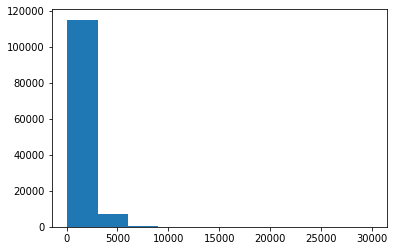

In [25]:
plt.hist(recipes_lengths)
plt.show()

In [26]:
MAX_RECIPE_LENGTH = 6000

In [27]:
for recipe_index, recipe in enumerate(dataset_vectorized[:10]):
    print('Recipe #{} length: {}'.format(recipe_index, len(recipe)))

Recipe #0 length: 582
Recipe #1 length: 437
Recipe #2 length: 707
Recipe #3 length: 772
Recipe #4 length: 1554
Recipe #5 length: 776
Recipe #6 length: 2717
Recipe #7 length: 875
Recipe #8 length: 703
Recipe #9 length: 1300


In [34]:
dataset_vectorized_padded_without_stops = tf.keras.preprocessing.sequence.pad_sequences(
    dataset_vectorized,
    padding='post',
    truncating='post',
    # We use -2 here to make sure that all recipes has at least 2 stops signs at the end.
    # Since each sequence will be shifted and truncated afterwards (to generate X and Y sequences)
    # we will be sure that all recipes will have at least 1 stop sign at the end.
    maxlen=MAX_RECIPE_LENGTH-2,
    value=tokenizer.texts_to_sequences([STOP_SIGN])[0]
)

In [35]:
dataset_vectorized_padded = tf.keras.preprocessing.sequence.pad_sequences(
    dataset_vectorized_padded_without_stops,
    padding='post',
    truncating='post',
    maxlen=MAX_RECIPE_LENGTH,
    value=tokenizer.texts_to_sequences([STOP_SIGN])[0]
)

In [36]:
for recipe_index, recipe in enumerate(dataset_vectorized_padded[:10]):
    print('Recipe #{} length: {}'.format(recipe_index, len(recipe)))

Recipe #0 length: 6000
Recipe #1 length: 6000
Recipe #2 length: 6000
Recipe #3 length: 6000
Recipe #4 length: 6000
Recipe #5 length: 6000
Recipe #6 length: 6000
Recipe #7 length: 6000
Recipe #8 length: 6000
Recipe #9 length: 6000


In [40]:
recipe_sequence_to_string(dataset_vectorized_padded[0])

[TITLE] 
Slow Cooker Chicken and Dumplings 

[INGREDIENTS] 
• 4 skinless, boneless chicken breast halves 
• 2 tablespoons butter 
• 2 (10.75 ounce) cans condensed cream of chicken soup 
• 1 onion, finely diced 
• 2 (10 ounce) packages refrigerated biscuit dough, torn into pieces 

[INSTRUCTIONS] 
▪︎ Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.
▪︎ Cover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.

★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★

### Create TensorFlow dataset 

In [31]:
dataset = tf.data.Dataset.from_tensor_slices(dataset_vectorized_padded)

print(dataset)

<TensorSliceDataset shapes: (6000,), types: tf.int32>


In [45]:
for recipe in dataset.take(1):
    print('Raw recipe:\n', recipe.numpy(), '\n\n\n')
    print('Stringified recipe:\n')
    recipe_sequence_to_string(recipe.numpy())

Raw recipe:
 [42 29 32 ... 62 62 62] 



Stringified recipe:

[TITLE] 
Slow Cooker Chicken and Dumplings 

[INGREDIENTS] 
• 4 skinless, boneless chicken breast halves 
• 2 tablespoons butter 
• 2 (10.75 ounce) cans condensed cream of chicken soup 
• 1 onion, finely diced 
• 2 (10 ounce) packages refrigerated biscuit dough, torn into pieces 

[INSTRUCTIONS] 
▪︎ Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.
▪︎ Cover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.

★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★